In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv('.\data\ks-projects-201801.csv')

In [3]:
#len(df), len(df.columns)

In [4]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [6]:
# add duration in days
df['duration'] = (pd.to_datetime(df['deadline']) - pd.to_datetime(df['launched'])).dt.days

In [7]:
# copy project name and id
df_names = df[['ID', 'name']].copy()

In [8]:
#df.to_excel("output.xlsx")

In [9]:
# convert text variables to categorical
text_col = ['category', 'main_category', 'country', 'currency']
df[text_col] = df[text_col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   ID                378661 non-null  int64   
 1   name              378657 non-null  object  
 2   category          378661 non-null  category
 3   main_category     378661 non-null  category
 4   currency          378661 non-null  category
 5   deadline          378661 non-null  object  
 6   goal              378661 non-null  float64 
 7   launched          378661 non-null  object  
 8   pledged           378661 non-null  float64 
 9   state             378661 non-null  object  
 10  backers           378661 non-null  int64   
 11  country           378661 non-null  category
 12  usd pledged       374864 non-null  float64 
 13  usd_pledged_real  378661 non-null  float64 
 14  usd_goal_real     378661 non-null  float64 
 15  duration          378661 non-null  int64   
dtypes:

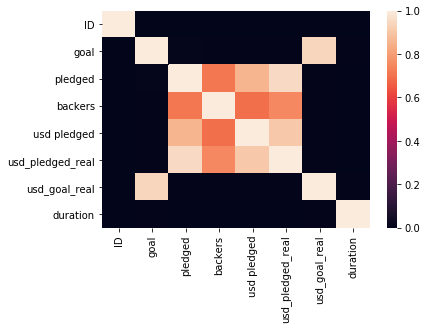

In [10]:
# find correlation between features
sns.heatmap(df.corr());

In [11]:
# remove unnecessary columns
df = df.drop(['ID', 'name', 'currency', 'launched', 'deadline', 'currency', 'usd pledged', 'usd_pledged_real', 'usd_goal_real'], axis=1)
df.head()

,category,main_category,goal,pledged,state,backers,country,duration
0,Poetry,Publishing,1000.0,0.0,failed,0,GB,58
1,Narrative Film,Film & Video,30000.0,2421.0,failed,15,US,59
2,Narrative Film,Film & Video,45000.0,220.0,failed,3,US,44
3,Music,Music,5000.0,1.0,failed,1,US,29
4,Film & Video,Film & Video,19500.0,1283.0,canceled,14,US,55


In [12]:
df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [13]:
# remove all states except 'failed' and 'successful'
df = df.loc[df['state'].isin(['failed', 'successful'])]
df['state'].value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

In [14]:
# map failed to 0 and successful to 1
df['state'] = df['state'].map({'failed': 0, 'successful': 1})
df['state'].value_counts()

0    197719
1    133956
Name: state, dtype: int64

In [15]:
# transform categoracal variables to columns
cols = df.select_dtypes('category').columns
df = pd.get_dummies(df, columns=df.select_dtypes('category').columns)
df.shape

(331675, 202)

In [18]:
# split dataset into matrix X with features and vector y with target
X, y = df.drop('state', axis=1), df['state']
X.shape, y.shape

((331675, 201), (331675,))

In [19]:
# split data into train and test
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=.3, random_state=8)
X_train.shape, X_test.shape

((232172, 201), (99503, 201))

In [20]:
# start build tree
tree = DecisionTreeClassifier(random_state=8)

In [21]:
# perform cross-validation
# parameters
params = {'max_depth': np.arange(2, 11), 'min_samples_leaf':  np.arange(1, 11)}

In [22]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [23]:
# start cross-validation. We use accuracy is a metric
best_tree = GridSearchCV(estimator=tree, param_grid=params, cv=skf, scoring='roc_auc', n_jobs=-1, verbose=1)

In [24]:
best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.6min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 17.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=8, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5

In [25]:
# best tree params
best_tree.best_params_

{'max_depth': 9, 'min_samples_leaf': 10}

In [26]:
best_tree.best_score_

0.9994736004279691

In [27]:
best_tree

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=8, splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': array([ 2,  3,  4,  5

In [28]:
# Holdout assesment of a best tree
pred_holdout_better = best_tree.predict(X_test)

In [30]:
roc_auc_score(y_test, pred_holdout_better)

0.998280954146071

In [31]:
# tree visualization
from io import StringIO
import pydotplus
from ipywidgets import Image

In [32]:
#dot_data = StringIO()
export_graphviz(decision_tree=best_tree.best_estimator_, out_file="tree_3.dot", filled=True,
                feature_names=df.drop('state', axis=1).columns)
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#Image(value=graph.create_png())